## Quick Docker Commands/Set-Up:


docker build -t "name" -f "Dockerfile.txt" .

docker build -t "get_complete" -f "Dockerfile.txt" .

---
```bash
docker run --entrypoint /bin/bash -it -v /Users/faith/Desktop/Coding:/home/xf2217 get_complete``

docker run -it -p 8888:8888 -v /Users/faith/Desktop/Coding:/home/xf2217  get_complete  jupyter notebook --allow-root --ip 0.0.0.0 --no-browser --NotebookApp.token='' --NotebookApp.password='' --notebook-dir=/home/xf2217
```

---

With Meluxina:
### *Solution:*

```bash
module load Python/3.11.3-GCCcore-12.3.0 

#If a package doesn't work.
rm -rf /home/users/u102501/.local/lib/python3.12/site-packages/urllib3*
python -m pip install --upgrade --force-reinstall urllib3
python -c "import urllib3; print(urllib3.__version__)"
```

```bash
apptainer exec --bind /project/home/p200469/get_BIO1018 get_complete_latest.sif python -m jupyter lab --no-browser --ip "*" --NotebookApp.token='' --NotebookApp.password='' --notebook-dir /project/home/p200469/get_BIO1018 --port 8888
```

Split terminal screen:

In local machine:

`ssh -L 8888:localhost:8888 [u102501@login.lxp.lu](mailto:u102501@login.lxp.lu) -p 8822 -i ~/.ssh/id_ed25519_mlux`

Enter passphrase,

Then,

`ssh -L 8888:localhost:8888 <mel0000>`  swap <> for your node.

## Start of Code:

In [30]:
#%%
from pathlib import Path

import numpy as np
import snapatac2 as snap
from gcell._settings import get_setting

annotation_dir = get_setting('annotation_dir')
print("gcell currently using annotation directory:", annotation_dir)

gcell currently using annotation directory: /home/users/u102501/.gcell_data/annotations


### Download the necessary files

## 0. Download cellranger-ARC processed data from 10x

wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5"

wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz"
#This one works and is a whopping 2.24GB!_

#wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz.tbi"
#This one says no such directory exists_

wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_peaks.bed"
wget "http://catlas.org/catlas_downloads/humantissues/cCRE_hg38.tsv.gz"

In [31]:
#cCRE

import pandas as pd
from pyranges import PyRanges as pr

#Here I've created a variable called cre which is an object related to the "cCRE_hg38.tsv.gz" file and stands for candidate cis-regulatory elements.
cre = pd.read_csv('cCRE_hg38.tsv.gz', sep='\t')
#Pandas which as an open-source Python library used for data manipulation and analysis. It's similar to dplyr on R. It can read and write Excel files
# So cre is the csv file that was downloaded and is read by the "pandas" tool which we made an alias to refer to is as "pd". Similar to R, the separator is noted.

cre = cre.rename(columns={'#Chromosome': 'Chromosome', 'hg38_Start': 'Start', 'hg38_End': 'End'})[['Chromosome', 'Start', 'End']]
#The line renames columns (#Chromosome to Chromosome, hg38_Start to Start, and hg38_End to End) and selects only the Chromosome, Start, and End columns for the cre DataFrame.

cre = pr(cre, int64=True).sort()
#This line converts the cre DataFrame into a PyRanges object with 64-bit integer precision (int64=True).
#Then sorts the genomic intervals in the object by their position (first by Chromosome and then by Start position).

cre.head()
#To view the first few lines of the file.

,Chromosome,Start,End
0,chr1,9955,10355
1,chr1,29163,29563
2,chr1,79215,79615
3,chr1,102755,103155
4,chr1,115530,115930
5,chr1,180580,180980
6,chr1,181273,181673
7,chr1,184281,184681


### Candidate Cis-Regulatory Elements
Candidate cis-regulatory elements are genomic regions identified as having potential regulatory functions, such as enhancers or promoters, that control gene expression. The file being referenced (cCRE_hg38.tsv.gz) likely contains information about these elements for the human genome (hg38 build).

__What Has Been Done so Far?__
1. Read in a cCRE file. (It's in a compressed from and separated by tabs) 
2. Renamed the columns and selected only the first three.
3. Converted the Pandas Dataframe to a Pranges object that is commonly used for genomic data and workflows (e.g., finding overlaps, merging regions). 
4. Then sorted the Pyranges object by Chromosome and then Start position.
5. Viewed first few lines to ensure all looks good.

__Adapting for MCF7__ 

Galaxy:
https://usegalaxy.eu/datasets/4838ba20a6d86765d1685afe6504d674/preview

ENCODE View:
https://www.encodeproject.org/search/?searchTerm=mcf7&type=Dataset #Overall MCF7 sample datasets
https://www.encodeproject.org/reference-epigenomes/ENCSR247DVY/ #MCF7 Reference - containing multiple bioassays.
https://www.encodeproject.org/annotations/ENCSR074VNQ/ #MCF7 cCRE annotation file - checked on Galaxy and is same format to one used in  tutorial.

In [32]:
#Sample Data

import scanpy as sc

ad = sc.read_10x_h5('pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5', gex_only=False)
ad

#This code uses the Scanpy library to read a 10x Genomics data file in HDF5 format. 
#Specifically, the file 'pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5' contains gene expression data from PBMC (peripheral blood mononuclear cells) and the method sc.read_10x_h5 is used to load this data into an AnnData object (stored in ad). 
#The gex_only=False argument means that both gene expression and other data types (e.g., ATAC-seq, if present) are read into the AnnData object.


/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11898 × 180488
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

__Adapting for MCF7__
The pbmc HDF5 dataset contains both gene expression and peak data in the one file.
For the initial stage of my project I will only be incoporating ATAC-Seq data from ENCODE using IDR thresholded peaks (.bed). Thus, some adaptations need to be made to the code.

This hdf5 contains the count matrix for both gene expression and peak count. CellRanger can show the peaks.

In [33]:
peaks = ad.var.query('feature_types == "Peaks"').interval.str.split(':|-').tolist()
# Extracts "Peaks" rows from the AnnData object (specifically the Feature types), splits the intervals by colon and hyphen into a list of values

peaks = pd.DataFrame(peaks, columns=['Chromosome', 'Start', 'End'])
# Converts the list of intervals into a pandas DataFrame with columns for Chromosome, Start, and End

peaks['Start'] = peaks['Start'].astype(int)
# Converts the 'Start' column values into integers

peaks['End'] = peaks['End'].astype(int)
# Converts the 'End' column values into integers

peaks = pr(peaks, int64=True).sort()
# Converts the pandas DataFrame into a PyRanges object and sorts the intervals

peaks.df.shape
# Returns the shape (number of rows and columns) of the PyRanges DataFrame

#This code processes genomic peak data, converting it into a more usable format for analysis.

(143887, 3)

### FuXi Note:
For optimal zero-shot analysis, it is recommended to use a union set of peaks from both the new dataset and the original training peak sets *(i.e. the cre peaks defined above)* to minimize domain shift. However, in this tutorial we will simply perform finetuning using the new peak set from the 10x PBMC multiome data. The union peak set can be constructed as below. After that you should re-count the peak count matrix using fragment file, and when write out cell-type specific peaks, ideally remove all non-accessible peaks in each cell types.

In [34]:
#peak / cre + cre 
#find all peaks that don't overlap with cre; -> non_overlap_peaks

non_overlap_peaks = peaks.overlap(cre, invert=True)
#invert=True: Ensures that only peaks outside the cre regions are kept. I.e. keeping peaks that don't overlap with cre.

#concat with cre and sort

total_peaks = pd.concat([non_overlap_peaks.df, cre.df], ignore_index=True)
total_peaks = pr(total_peaks, int64=True).sort()

#remove chromosome M, Y and those not start with chr
total_peaks = total_peaks.df.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')
total_peaks.shape

(1164363, 3)

### What is the Purpose of This?

In this code, cre represents candidate cis-regulatory elements (genomic regions with potential regulatory roles), while peaks represents regions of open chromatin from the experimental data, inferred from ATAC-seq or other assays.

The overlapping is done to identify non-overlapping peaks using:

This step filters peaks that do not overlap with the cCRE regions. The purpose is to isolate peaks not previously annotated as regulatory elements, which may contain novel or unique regions worth further analysis.

### FuXi Note:
For convenience, we will keep using the peak set called by cellranger here。 Note that there is a difference in peak length distribution. However, in general there are no peaks > 1000 bp; and most peaks have a length in order of 10^3 so let's keep using this one. Note that the original training CRE peak set has a unified length of 400 bp.

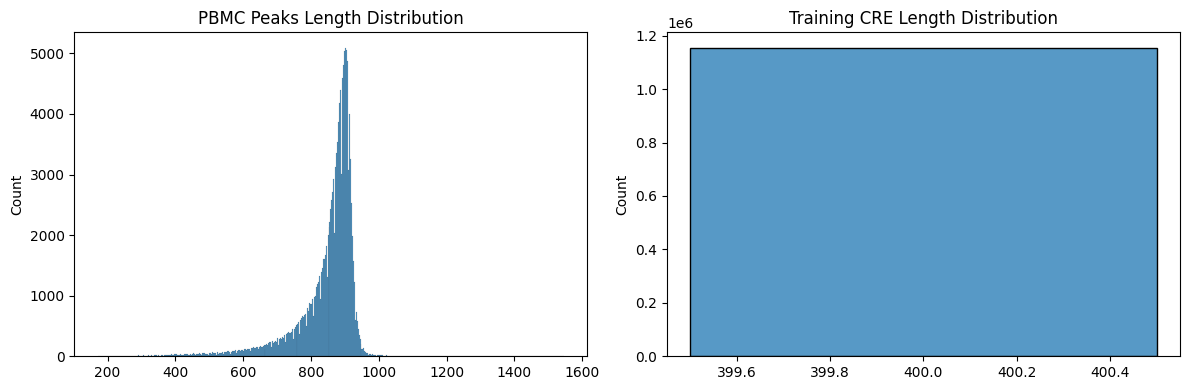

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#plt.subplots(1, 2, figsize=(12, 4)): This creates a figure with two subplots arranged horizontally (1 row, 2 columns).
#The figsize=(12, 4) argument specifies the dimensions of the overall figure in inches (width = 12 inches, height = 4 inches).
#ax1, ax2: These are the axes for the left and right subplots, respectively. 

sns.histplot(peaks.End-peaks.Start, ax=ax1)
#sns.histplot(peaks.End-peaks.Start, ax=ax1): This plots a histogram of the length of each peak in the peaks DataFrame. 
#The length is calculated by subtracting the Start coordinate from the End coordinate (peaks.End - peaks.Start), which gives the length of each peak region.
#The ax=ax1 argument tells Seaborn to plot this histogram on the left subplot (ax1).

ax1.set_title('PBMC Peaks Length Distribution')

sns.histplot(cre.End-cre.Start, ax=ax2)  
#sns.histplot(cre.End-cre.Start, ax=ax2): This plots a histogram of the length of each candidate cis-regulatory element (CRE) in the cre DataFrame.
#Similarly, the length is calculated by subtracting the Start coordinate from the End coordinate (cre.End - cre.Start).
#The ax=ax2 argument tells Seaborn to plot this histogram on the right subplot (ax2).

ax2.set_title('Training CRE Length Distribution')

plt.tight_layout()

### Adapting Code to MCF-7
When I'm doing this again. The PMBC dataset will be swapped for MCF-7 dataset (already downloaded).
Similarly, a cCRE dataset specific to MCF-7 will be used.

The goal is to step away from generalization and move towards a specific GET model.

## 1. Cell Type Assignment
1. Load RNA data from processed PBMC10k dataset and borrow the labels. If you have your own cell type labels on the data, skip this step.
2. Select top 3000 highly variable genes and perform UMAP to cross check with assigned labels.

In [36]:
# %%
# read rna data

# Check if the file 'rna.h5ad' already exists in the directory
if not Path('rna.h5ad').exists():

    # If the file doesn't exist, load the RNA data using SnapATAC's method for PBMC 10k multiome dataset
    rna = snap.read(snap.datasets.pbmc10k_multiome(modality='RNA'), backed=None)

    # Identify the 3000 most variable genes in the dataset using the 'Seurat v3' method
    sc.pp.highly_variable_genes(rna, flavor='seurat_v3', n_top_genes=3000)

    # Filter the RNA data to keep only the highly variable genes
    rna_filtered = rna[:, rna.var.highly_variable]

    # Normalize the filtered RNA data so that the total counts per cell sum to 10,000 (target_sum=1e4)
    sc.pp.normalize_total(rna_filtered, target_sum=1e4)

    # Apply a logarithmic transformation to the RNA data to reduce skewness in the data distribution
    sc.pp.log1p(rna_filtered)

    # Perform spectral decomposition to reduce dimensionality and extract features from the RNA data
    snap.tl.spectral(rna_filtered, features=None)

    # Perform UMAP (Uniform Manifold Approximation and Projection), a dimensionality reduction method for visualizing the data
    snap.tl.umap(rna_filtered)
    
    # Save the filtered and processed RNA data into a file called 'rna.h5ad'    
    rna_filtered.write('rna.h5ad')

# If the file 'rna.h5ad' already exists, load the processed data from that file instead of reprocessing it
else:
    rna_filtered = sc.read('rna.h5ad')

/opt/conda/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Here, I'm going to use the cell type labels from preprocessed snapatac2 object.
Remember, ad is the PMBC (swap for MCF-7) dataset (i.e. the sample/experimentation)

### FuXi Note:
Here, I'm going to use the cell type labels from preprocessed snapatac2 object.

In [37]:
ad = ad[ad.obs.index.isin(rna_filtered.obs.index.values)]
#Used to filter the ad AnnData object to retain only the cells (observations) that are also present in the rna_filtered AnnData object.

### Difference Between `ad` and `rna_filtered`

The difference between `ad` and `rna_filtered` lies in their roles and processing states within your data pipeline for analyzing single-cell data:

1. `ad`:
- `ad` is the initial **AnnData** object created when you load the multi-modal (e.g., RNA and ATAC-seq) dataset using `sc.read_10x_h5`.
- It contains all the raw features from the original dataset, including gene expression and peak counts, along with other metadata.
- The data in `ad` has not yet been processed or filtered for specific analyses. It represents the starting point for downstream steps.

2. `rna_filtered`:
- `rna_filtered` is a processed version of the RNA data extracted from the original dataset (or from a separate RNA-focused dataset).
- Steps performed to create `rna_filtered` include:
  - **Selection of highly variable genes**: Focuses the analysis on the most informative genes.
  - **Normalization**: Ensures that each cell’s data is scaled to a comparable level.
  - **Log-transformation**: Reduces the skew in data distribution, making it more suitable for downstream analyses.
  - **Dimensionality reduction** (e.g., spectral decomposition and UMAP): Prepares the data for visualization and clustering.

### Summary of Roles:
- **`ad`**: A comprehensive container for the entire raw dataset, serving as the basis for extracting specific modalities (e.g., gene expression or ATAC-seq peaks).
- **`rna_filtered`**: A refined and processed subset of `ad` focused on RNA (gene expression) data, optimized for analysis and visualization.

By filtering and normalizing `rna_filtered`, you enhance its utility for identifying cell types, discovering gene markers, or integrating with other modalities (like ATAC).

In [38]:
barcode_to_celltype = rna_filtered.obs.to_dict()['cell_type']

ad.obs['cell_type'] = ad.obs.index.map(barcode_to_celltype)

/tmp/ipykernel_30669/3222849866.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['cell_type'] = ad.obs.index.map(barcode_to_celltype)
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


1. **`barcode_to_celltype = rna_filtered.obs.to_dict()['cell_type']`**:
   - `.to_dict()` converts this DataFrame into a dictionary. The key `'cell_type'` refers to a column in this DataFrame that contains the cell type information.
   - As a result, `barcode_to_celltype` becomes a dictionary where the keys are cell barcodes (e.g., unique identifiers for cells), and the values are the corresponding cell types for each barcode.

2. **`ad.obs['cell_type'] = ad.obs.index.map(barcode_to_celltype)`**:
   - `.index` gives the index (row labels) of the DataFrame, which should correspond to the cell barcodes.
   - `.map(barcode_to_celltype)` uses the dictionary `barcode_to_celltype` to map the cell type information from the `barcode_to_celltype` dictionary to the index (cell barcodes) in `ad.obs`.
   - The result is that a new column, `'cell_type'`, is added to `ad.obs`, containing the cell type for each barcode.

In summary, this code creates a mapping from barcodes to cell types using `rna_filtered.obs`, then uses this mapping to add a `'cell_type'` column to `ad.obs` by matching the barcodes in `ad.obs.index` to the `barcode_to_celltype` dictionary.

In [39]:
ad.obs.head()

,cell_type
AAACAGCCAATCCCTT-1,CD4 TCM
AAACAGCCAATGCGCT-1,CD4 Naive
AAACAGCCACCAACCG-1,CD8 Naive
AAACAGCCAGGATAAC-1,CD4 Naive
AAACAGCCAGTTTACG-1,CD4 TCM


In [40]:
ad_rna = ad[:, np.where(ad.var.feature_types == 'Gene Expression')[0]]
# Filter the AnnData object to retain only features of type 'Gene Expression' and store the result in ad_rna

ad_rna

View of AnnData object with n_obs × n_vars = 9627 × 36601
    obs: 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

### FuXi Note:
Let's calculate the umap on the ad_rna and compare the clustering with assigned cell type labels. In your own analysis, if you already have the labels, you can skip this.

/opt/conda/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

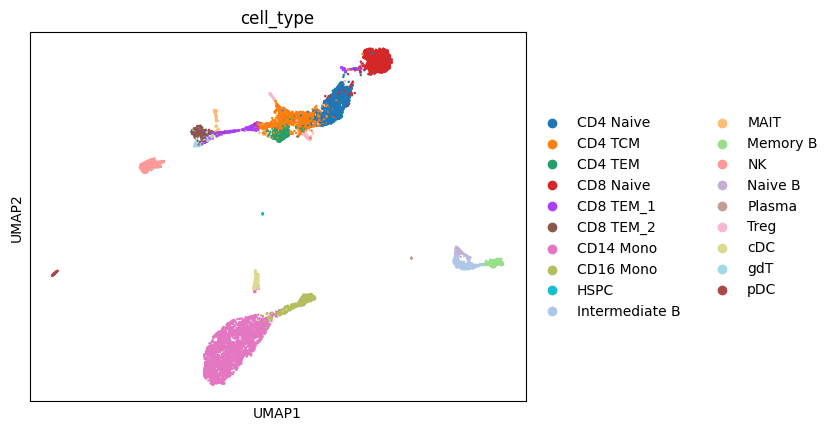

In [41]:
# Identify the top 3000 highly variable genes in the ad_rna object using the Seurat v3 method
sc.pp.highly_variable_genes(ad_rna, flavor='seurat_v3', n_top_genes=3000)

# Filter ad_rna to retain only the highly variable genes identified in the previous step
ad_rna_filtered = ad_rna[:, ad_rna.var.highly_variable]

# Normalize the total counts of each cell in ad_rna_filtered to a target sum of 10,000
sc.pp.normalize_total(ad_rna_filtered, target_sum=1e4)

# Log-transform the data in ad_rna_filtered for variance stabilization and normalization
sc.pp.log1p(ad_rna_filtered)

# Perform spectral clustering on the ad_rna_filtered object to identify clusters or groups in the data
snap.tl.spectral(ad_rna_filtered, features=None)

# Run UMAP (Uniform Manifold Approximation and Projection) for dimensionality reduction on ad_rna_filtered
snap.tl.umap(ad_rna_filtered)

# Plot the UMAP representation of ad_rna_filtered, coloring the cells by their 'cell_type' annotation
sc.pl.umap(ad_rna_filtered, color='cell_type')

### FuXi Note:
It seems the cell types match well with the data. So now let's collect the ATAC object and look at library sizes of different cell types. Note that if you have a very densely sampled dataset, you can also perform metacell analysis and sample pseudobulk with a consistent library size.

In [42]:
# Filter the AnnData object to retain only features of type 'Peaks' and store the result in ad_atac
ad_atac = ad[:, np.where(ad.var.feature_types == 'Peaks')[0]]

# Display the filtered ad_atac object containing only 'Peaks' features
ad_atac

View of AnnData object with n_obs × n_vars = 9627 × 143887
    obs: 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

### FuXi Note:
We filter for cell types with >100 cells and at least 3M library size.
The selected cell types will be used for training GET models.

In [43]:
# Count the number of cells for each 'cell_type' in ad_atac and store the result as a dictionary
cell_number = ad_atac.obs.groupby('cell_type', observed=False).size().to_dict()

# Print a message indicating the filtering criteria for cell types to be added to celltype_for_modeling
print("The following cell types have more than 100 cells and library size > 3M, adding them to celltype_for_modeling")

# Initialize an empty list to store cell types that meet the criteria for modeling
celltype_for_modeling = []

# Loop through each cell type and its corresponding cell count
for cell_type in cell_number:
    # If the cell type has more than 100 cells, proceed to check library size
    if cell_number[cell_type] > 100:
        # Add the cell type to the list for modeling
        celltype_for_modeling.append(cell_type)
        
        # Calculate the library size for the current cell type by summing the expression values
        libsize = int(ad_atac[ad_atac.obs.cell_type == cell_type].X.sum())
        
        # If the library size is greater than 3 million, print the cell type, its count, and the library size
        if libsize > 3000000:
            print(f"{cell_type} number of cells: {cell_number[cell_type]}, library size: {libsize}")


The following cell types have more than 100 cells and library size > 3M, adding them to celltype_for_modeling
CD14 Mono number of cells: 2551, library size: 62039712
CD16 Mono number of cells: 442, library size: 10504281
CD4 Naive number of cells: 1382, library size: 29601700
CD4 TCM number of cells: 1113, library size: 24745884
CD4 TEM number of cells: 286, library size: 6965094
CD8 Naive number of cells: 1353, library size: 30763516
CD8 TEM_1 number of cells: 322, library size: 7209424
CD8 TEM_2 number of cells: 315, library size: 6378479
Intermediate B number of cells: 300, library size: 8366581
MAIT number of cells: 130, library size: 3290943
Memory B number of cells: 298, library size: 7267452
NK number of cells: 403, library size: 8665433
Naive B number of cells: 125, library size: 3618917
Treg number of cells: 157, library size: 3135736
cDC number of cells: 180, library size: 6102032
gdT number of cells: 143, library size: 3106695


## 2. Export Training Data

### FuXi Note:
For each abundant cell type, we'll generate:

Peak accessibility file (.atac.bed) containing:  
Peak coordinates (chr, start, end)  
Normalized accessibility scores (aCPM, 10^5 scale factor) 
 
Gene expression file (.rna.csv) containing:  
Gene names  
Normalized expression values (TPM, 10^6 scale factor)  

In [44]:
# This should be the same as the peaks variable defined above.

# Import pandas library for data manipulation and pyranges for genomic range operations
import pandas as pd
from pyranges import PyRanges as pr

# Define a function to extract peak names from a snapatac2 processed AnnData object
def get_peak_from_snapatac(atac: snap.AnnData):
    """
    Get the peak names from the snapatac object.

    Args:
        atac: snapatac2 processed AnnData object

    Returns:
        peak_names: pandas DataFrame with the peak names
    """
    # Split the feature names (e.g., Chromosome:Start-End) into separate columns: 'Chromosome', 'Start', 'End'
    peak_names = pd.DataFrame(atac.var.index.str.split('[:-]').tolist(), columns=['Chromosome', 'Start', 'End'])
    
    # Convert the 'Start' and 'End' columns to integer type for numerical operations
    peak_names['Start'] = peak_names['Start'].astype(int)
    peak_names['End'] = peak_names['End'].astype(int)
    
    # Return the DataFrame containing the peak names with chromosome positions
    return peak_names

# Call the function on the ad_atac object to extract the peak names
peaks = get_peak_from_snapatac(ad_atac)

# Display the shape (dimensions) of the DataFrame containing peak names
peaks.shape

(143887, 3)

In [45]:
# %%
# Define a function to calculate the aCPM (normalized counts) for a given cell type
def get_peak_acpm_for_cell_type(atac: snap.AnnData, cell_type: str):
    """
    Get the peak acpm for a given cell type.
    """
    # Get the peak names and positions from the snapatac object using the previously defined function
    peaks = get_peak_from_snapatac(atac)
    
    # Get the summed counts for each peak in the given cell type
    counts = np.array(atac[atac.obs.cell_type == cell_type].X.sum(0)).flatten()
    
    # Calculate the aCPM (counts per million) and apply log10 transformation
    acpm = np.log10(counts / counts.sum() * 1e5 + 1)
    
    # Normalize the aCPM values so that the maximum value is 1
    peaks['aCPM'] = acpm / acpm.max()
    
    # Filter peaks to include only those from chromosomes that start with 'chr' and exclude 'M', 'Y', and 'chrUn'
    peaks = peaks.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')
    
    # Convert the filtered peaks DataFrame to a PyRanges object and sort it
    peaks = pr(peaks, int64=True).sort().df
    
    # Return the processed peaks DataFrame
    return peaks


### FuXi Note:
Let's run the function above to save the peak with aCPM for all cell types. Note that here we use the common peak set for all cell types. Later in the dataset we will be able to filter out peaks with no accessibility for each cell type.

<Axes: xlabel='aCPM', ylabel='length'>

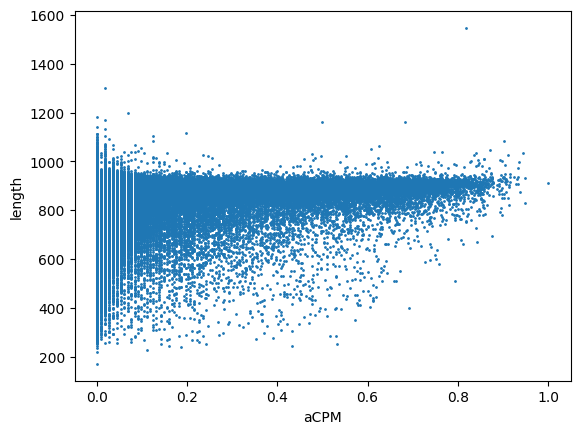

In [46]:
# %%
# Loop through each cell type in the list 'celltype_for_modeling'
for cell_type in celltype_for_modeling:
    # For each cell type, get the peak aCPM (normalized counts) using the previously defined function
    peaks = get_peak_acpm_for_cell_type(ad_atac, cell_type)
    
    # Save the processed peaks as a tab-delimited .bed file, with the cell type name as the filename
    peaks.to_csv(f'{cell_type.replace(" ", "_").lower()}.atac.bed', sep='\t', index=False, header=False)

# Add a new column 'length' to the peaks DataFrame, calculating the length of each peak (End - Start)
peaks['length'] = peaks['End'] - peaks['Start']

# Create a scatter plot of 'length' vs 'aCPM' to visualize the relationship between peak length and aCPM
peaks.plot(y='length', x='aCPM', kind='scatter', s=1)

In [48]:
peaks

,Chromosome,Start,End,aCPM,length
0,chr1,9790,10675,0.068361,885
1,chr1,180599,181702,0.123942,1103
2,chr1,191168,192093,0.018614,925
3,chr1,267565,268455,0.018614,890
4,chr1,270876,271770,0.000000,894
...,...,...,...,...,...
143820,chrX,155896411,155896852,0.000000,441
143821,chrX,155966624,155967524,0.000000,900
143822,chrX,155997155,155998067,0.117535,912
143823,chrX,156024967,156025615,0.018614,648


### FuXi Note:
Now let's save the RNA csv files.

In [49]:
# %%
# Define a function to calculate TPM (transcripts per million) for a given cell type
def get_rna_for_cell_type(rna: snap.AnnData, cell_type: str):
    """
    Get the RNA counts for a given cell type, normalized as TPM.
    """
    # Sum the counts for each gene in the specified cell type
    counts = rna[rna.obs.cell_type == cell_type].X.sum(0)
    
    # Normalize the counts to TPM by dividing by the total counts, scaling to 1 million, and applying a log10 transformation
    counts = np.log10(counts / counts.sum() * 1e6 + 1)
    
    # Flatten the counts array for use in a DataFrame
    counts = np.array(counts).flatten()
    
    # Create a DataFrame with the TPM values and corresponding gene names
    rna_tpm = pd.DataFrame(counts, columns=['TPM'])
    rna_tpm['gene_name'] = rna.var.index
    
    # Return the DataFrame with 'gene_name' and 'TPM', sorted by gene name in ascending order
    return rna_tpm[['gene_name', 'TPM']].sort_values(by='gene_name', ascending=True)


In [50]:
# %%
# Loop through each cell type in the list 'celltype_for_modeling'
for cell_type in celltype_for_modeling:
    # For each cell type, get the RNA TPM (transcripts per million) using the previously defined function
    rna_tpm = get_rna_for_cell_type(ad_rna, cell_type)
    
    # Save the resulting RNA TPM DataFrame as a CSV file with the cell type name (converted to lowercase and with spaces replaced by underscores)
    rna_tpm.to_csv(f'{cell_type.replace(" ", "_").lower()}.rna.csv', index=False)

## 3. Query motifs and save data as zarr files.

In [51]:
# NOTE: tabix has to be >= 1.17
! tabix --version

tabix (htslib) 1.21
Copyright (C) 2024 Genome Research Ltd.


In [52]:
# Import the necessary libraries and modules
import os
from pathlib import Path

# Import specific functions from the 'gcell._settings' module and 'preprocess_utils' module
from gcell._settings import get_setting
from preprocess_utils import (
    add_atpm,        # Function to add ATPM
    add_exp,         # Function to add expression data
    create_peak_motif,  # Function to create peak motif data
    download_motif,     # Function to download motif data
    get_motif,          # Function to retrieve motif data
    query_motif,        # Function to query motif data
)

# Get the annotation directory setting using the 'get_setting' function and convert it to a Path object
annotation_dir = Path(get_setting('annotation_dir'))

# Print the directory being used for annotations (retrieved from the configuration)
print("gcell currently using annotation directory:", annotation_dir)

gcell currently using annotation directory: /home/users/u102501/.gcell_data/annotations


### Download motif bed file

In [53]:
motif_bed_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz"
motif_bed_index_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz.tbi"


if (
    motif_bed_url
    and motif_bed_index_url
    and not (
        (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz").exists()
        or (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz.tbi").exists()
    )
):
    download_motif(motif_bed_url, motif_bed_index_url, motif_dir=annotation_dir)
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")
else:
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")

### Query Motif

In [54]:
peak_bed = "cd4_naive.atac.bed" # since all cell types share the same peak set, when querying motifs, we can just use one cell type to query motifs.
peaks_motif = query_motif(peak_bed, motif_bed)
get_motif_output = get_motif(peak_bed, peaks_motif)

Peak motif extraction completed. Results saved in get_motif.bed


## 4. Create Peak Motif .Zarr File

Create a peak x motif matrix stored in a zarr file. If you are working on multiple cell types with the same peak set, you can use the same peak bed and zarr file for all cell types.


In [55]:
create_peak_motif(get_motif_output, "pbmc10k_multiome.zarr", peak_bed) 
# all cell types will later be added to the same zarr file as we use the same peak set.

Peak motif data saved to pbmc10k_multiome.zarr


### Add aCPM data to region x motif matrix

For each cell type, we will save it's aCPM values to the pbmc10k_multiome.zarr/atpm/{celltype}/ folder

In [56]:
#CD14 Mono number of cells: 2551, library size: 62039712
#CD16 Mono number of cells: 442, library size: 10504281
#CD4 Naive number of cells: 1382, library size: 29601700
#CD4 TCM number of cells: 1113, library size: 24745884
#CD4 TEM number of cells: 286, library size: 6965094
#CD8 Naive number of cells: 1353, library size: 30763516
#CD8 TEM_1 number of cells: 322, library size: 7209424
#CD8 TEM_2 number of cells: 315, library size: 6378479
#Intermediate B number of cells: 300, library size: 8366581
#MAIT number of cells: 130, library size: 3290943
#Memory B number of cells: 298, library size: 7267452
#NK number of cells: 403, library size: 8665433
#Naive B number of cells: 125, library size: 3618917
#Treg number of cells: 157, library size: 3135736
#cDC number of cells: 180, library size: 6102032
#gdT number of cells: 143, library size: 3106695

celltype_for_modeling = [
    'cd14_mono',
    'cd16_mono',
    'cd4_naive',
    'cd4_tcm',
    'cd4_tem',
    'cd8_naive',
    'cd8_tem_1',
    'cd8_tem_2',
    'intermediate_b',
    'mait',
    'memory_b',
    'naive_b',
    'treg',
    'cdc',
    'gdt',
    'nk',
 ]

In [57]:
for cell_type in celltype_for_modeling:
    add_atpm(
        "pbmc10k_multiome.zarr",
        f"{cell_type}.atac.bed",
        cell_type,
    )

       Chromosome      Start        End      aTPM                      Name
0            chr1       9790      10675  0.016197           chr1:9790-10675
1            chr1     180599     181702  0.031115        chr1:180599-181702
2            chr1     191168     192093  0.032358        chr1:191168-192093
3            chr1     267565     268455  0.097888        chr1:267565-268455
4            chr1     270876     271770  0.045691        chr1:270876-271770
...           ...        ...        ...       ...                       ...
143820       chrX  155896411  155896852  0.011344  chrX:155896411-155896852
143821       chrX  155966624  155967524  0.007312  chrX:155966624-155967524
143822       chrX  155997155  155998067  0.002764  chrX:155997155-155998067
143823       chrX  156024967  156025615  0.005955  chrX:156024967-156025615
143824       chrX  156030098  156030882  0.034008  chrX:156030098-156030882

[143825 rows x 5 columns]
       Chromosome      Start        End      aTPM            

### Add Expression and TSS Data to Region x Motif Matrix

In [58]:
# Loop through each cell type in the list 'celltype_for_modeling'
for cell_type in celltype_for_modeling:
    add_exp(
        "pbmc10k_multiome.zarr",
        f"{cell_type}.rna.csv",
        f"{cell_type}.atac.bed",
        cell_type,
        assembly="hg38",
        version=44,
        extend_bp=300, # extend TSS region to 300bp upstream and downstream when overlapping with peaks
    id_or_name="gene_name", # use gene_name or gene_id to match the gene expression data, checkout your rna.csv file column names, should be either [gene_name, TPM] or [gene_id, TPM]
)

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
/project/home/p200469/get_BIO1018/preprocess_utils/preprocess_utils.py:338: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["index", "Strand"])
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
/project/home/p200469/get_BIO1018/preprocess_utils/preprocess_utils.py:338: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt t

OSError: [Errno 122] Disk quota exceeded: '/project/home/p200469/get_BIO1018/pbmc10k_multiome.zarr/expression_positive/cd16_mono/23.77ce7a97503e4ffe831b832ab4d2774f.partial'

### Clean up Intermediate Files

In [ ]:
for file in [peaks_motif, get_motif_output]:
    os.remove(file)

### FuXi Note:

This has conclude the data processing steps.